# Fase 3: Análisis de Subespacios Semánticos
## "De vectores a geometrías evolutivas"

**Objetivo Educativo**: Este notebook explica cómo transformamos listas de vectores (embeddings) en estructuras geométricas estables que nos permitan medir la evolución del significado de "Yape" en el tiempo.

### Pasos de la Fase 3:
1.  **Segmentación Temporal** (Fase 3.1 - *Implementado*): Dividir el tiempo en "ventanas deslizantes" para suavizar el ruido.
2.  **Análisis de Dimensionalidad** (Fase 3.2 - *Pendiente*): Determinar cuántas dimensiones ($k$) son reales.
3.  **Construcción de Subespacios** (Fase 3.3 - *Pendiente*): Aplicar SVD y alinamiento.
4.  **Métricas Sociológicas** (Fase 3.4 - *Pendiente*): Calcular deriva y proyecciones.


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Asegurar que podemos importar los módulos del proyecto
sys.path.append(os.path.abspath('..'))

from src.analysis.temporal import TemporalSegmenter

# Configuración de gráficos
plt.style.use('seaborn-v0_8')
%matplotlib inline

## Paso 1: Carga de Datos Reales
En lugar de simular, cargaremos los embeddings reales extraídos en la Fase 2.
Archivo: `data/embeddings_test_cli.parquet`
Dimensiones esperadas:
*   **Filas (N)**: Ocurrencias del término (Noticias).
*   **Columnas (D)**: Dimensiones del vector (3072 para Concatenación de últimas 4 capas de BERT Base).

**Importante**: Para el SVD, la matriz debe tener la forma $(N, D)$. Reduciremos la dimensionalidad $D$ basándonos en la varianza de $N$.


Archivos encontrados: ['../data/embeddings_multi_test.parquet', '../data/embeddings_test_cli.parquet']
Total registros cargados (Crudo): 1976
Total registros tras borrar duplicados: 784
Dimensión del embedding: 3072
Matriz de Embeddings: (784, 3072)


/tmp/ipykernel_27474/2693582622.py:49: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_demo['date'].groupby(df_demo.date.dt.to_period('M')).count().plot(kind='bar', figsize=(12, 4), title="Distribución Total de Noticias")


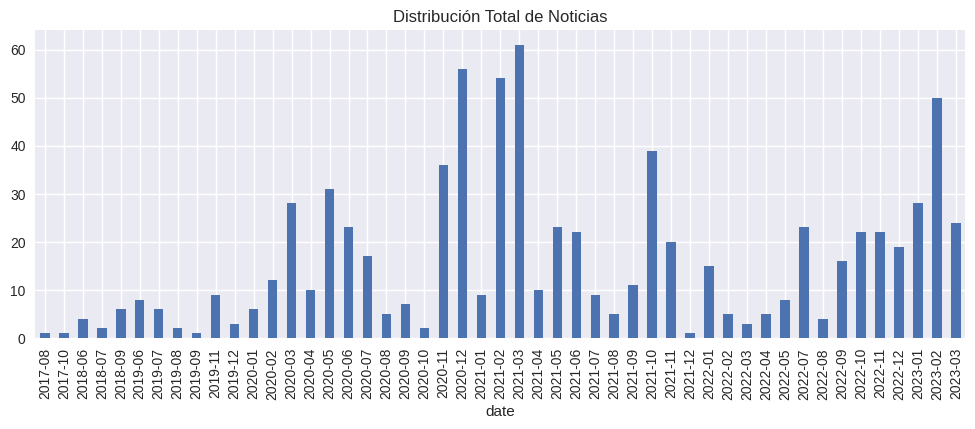

In [2]:
# Cargar datos reales (Todos los disponibles)
import glob

# Buscar todos los parquets de embeddings
search_patterns = [
    'data/embeddings_*.parquet',
    '../data/embeddings_*.parquet',
    os.path.join(os.getcwd(), 'data', 'embeddings_*.parquet')
]

found_files = set()
for pattern in search_patterns:
    found_files.update(glob.glob(pattern))
    
# Filtrar 'anchors' que es otro tipo de archivo
parquet_files = [f for f in found_files if 'anchors' not in f]
parquet_files = sorted(list(parquet_files))

if parquet_files:
    print(f"Archivos encontrados: {parquet_files}")
    dfs = []
    for p in parquet_files:
        try:
            d = pd.read_parquet(p)
            dfs.append(d)
        except Exception as e:
            print(f"Error leyendo {p}: {e}")
            
    df_real = pd.concat(dfs, ignore_index=True)
    print(f"Total registros cargados (Crudo): {len(df_real)}")
    
    # --- AUDIT FIX: REMOVE DUPLICATES ---
    # Embeddings arrays cannot be used for drop_duplicates directy.
    # We create a hash for deduplication.
    df_real['hash'] = df_real['embedding'].apply(lambda x: hash(x.tobytes()))
    df_real = df_real.drop_duplicates(subset=['hash'])
    print(f"Total registros tras borrar duplicados: {len(df_real)}")
    
    # Validar dimensiones
    sample_emb = df_real.iloc[0]['embedding']
    print(f"Dimensión del embedding: {len(sample_emb)}")
    
    matrix_stack = np.vstack(df_real['embedding'].values)
    print(f"Matriz de Embeddings: {matrix_stack.shape}")
    
    df_demo = df_real.copy()
    df_demo['date'] = pd.to_datetime(df_demo['date'])
    
    df_demo['date'].groupby(df_demo.date.dt.to_period('M')).count().plot(kind='bar', figsize=(12, 4), title="Distribución Total de Noticias")
    plt.show()
else:
    print("ERROR FATAL: No se encontraron archivos de embeddings.")


## Paso 2: Segmentación Temporal (Rolling Windows)
**Fase 3.1**

En sociología, el significado no cambia de un día para otro. Si analizamos día a día, el ruido nos ciega. Si analizamos año a año, perdemos los detalles.

**Solución**: Ventanas Deslizantes (*Rolling Windows*).
*   **Tamaño (Window Size)**: 3 meses. (Para tener densidad suficiente).
*   **Paso (Step)**: 1 mes. (Para ver la evolución suave).

*Ejemplo*: Ene-Mar -> Feb-Abr -> Mar-May...

Usaremos la clase `TemporalSegmenter` que hemos implementado en `src/analysis/temporal.py`.

Se han generado 21 ventanas temporales válidas.


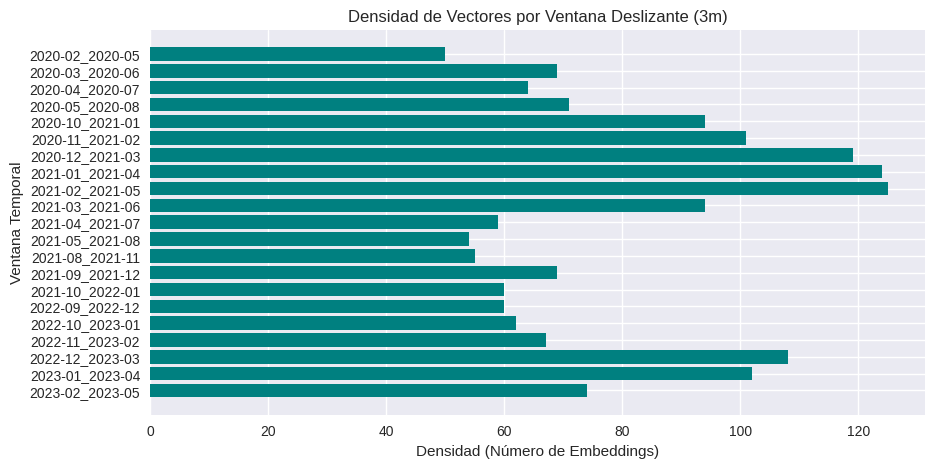

In [3]:
# Inicializar el Segmentador
segmenter = TemporalSegmenter(df_demo, date_column='date')

# Generar Ventanas (3 meses, paso 1 mes, mínimo 50 datos)
windows = list(segmenter.generate_windows(window_months=3, step_months=1, min_count=50))

print(f"Se han generado {len(windows)} ventanas temporales válidas.")

# Visualizar la cobertura de las ventanas
window_labels = [w['label'] for w in windows]
counts = [w['count'] for w in windows]

plt.figure(figsize=(10, 5))
plt.barh(window_labels, counts, color='teal')
plt.xlabel("Densidad (Número de Embeddings)")
plt.ylabel("Ventana Temporal")
plt.title("Densidad de Vectores por Ventana Deslizante (3m)")
plt.gca().invert_yaxis() # Invertir para ver cronológico de arriba a abajo
plt.show()

### ¿Por qué es importante esto?
Observa en el gráfico cómo cada ventana garantiza un mínimo de muestras. Esto es crucial para el siguiente paso: **SVD (Singular Value Decomposition)**. 
Para calcular las dimensiones latentes de forma fiable, necesitamos que la matriz $X_t$ (filas=noticias, col=dimensiones) sea suficientemente "alta" (muchas filas) respecto a su rango.

Si alguna ventana tuviera muy pocos datos (ej. < 50), el algoritmo la descarta automáticamente para proteger la integridad científica del estudio.


## Paso 3: Análisis de Dimensionalidad (Horn's Parallel Analysis)
**Fase 3.2**

¿Cuántas "dimensiones" tiene el significado de Yape? ¿2? ¿5? ¿10? 
En lugar de decidir arbitrariamente, usamos el **Análisis Paralelo de Horn**.

**Lógica**:
1. Calculamos los "autovalores" (fuerza de cada dimensión) de nuestros datos reales.
2. Generamos 20 matrices de **ruido aleatorio** puro con la misma forma.
3. Solo aceptamos una dimensión si su fuerza es **significativamente mayor** (percentil 95) que la que produciría el azar.

Usaremos `src.analysis.dimensionality.SubspaceAnalyzer`.

Analizando ventana inicial: 2020-02_2020-05 (Shape: (50, 3072))



>> Número Óptimo de Dimensiones (k) Ventana Inicial: 2
Varianza explicada por los primeros 2 componentes: 92.84%


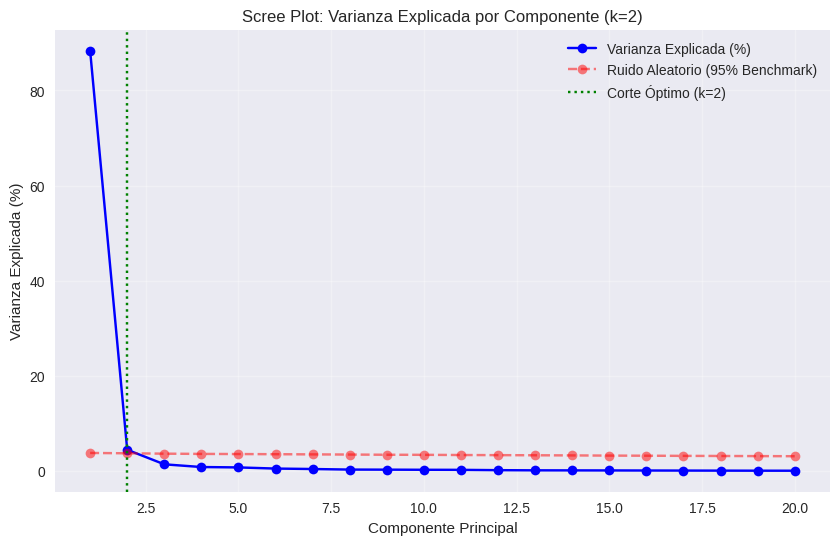

Varianza acumulada k=2: 92.84%

Calculando Evolución de Dimensionalidad (K) por Ventana...


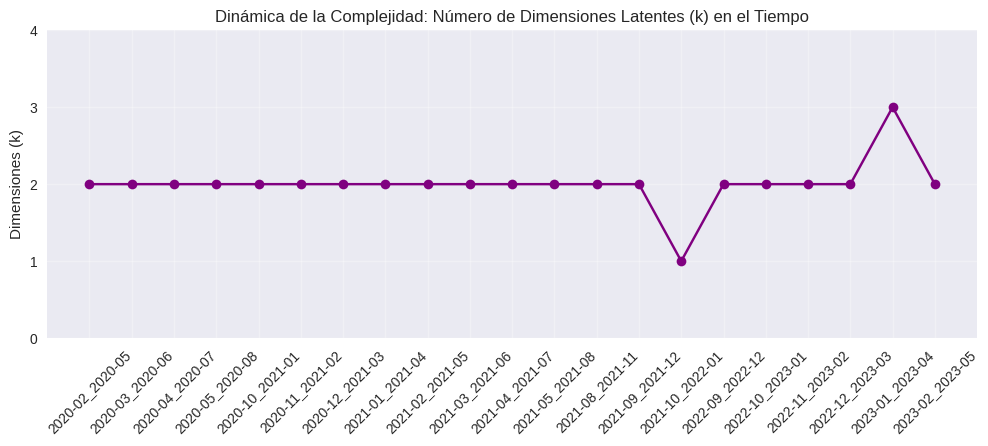

In [4]:
from src.analysis.dimensionality import SubspaceAnalyzer

# Ejecutar Horn's PA en la primera ventana para tener una referencia visual detallada
if len(windows) > 0:
    window_0 = windows[0]
    data_matrix = np.vstack(window_0['data']['embedding'].values) 
    print(f"Analizando ventana inicial: {window_0['label']} (Shape: {data_matrix.shape})")

    analyzer = SubspaceAnalyzer(random_state=42)
    k_opt, real_sv, thresholds = analyzer.horns_parallel_analysis(data_matrix, num_simulations=20)
    
    # Calcular Varianza Explicada Normalizada (%)
    real_eigenvals = real_sv ** 2
    total_variance = np.sum(real_eigenvals)
    explained_variance_ratio = real_eigenvals / total_variance * 100 
    
    print(f"\n>> Número Óptimo de Dimensiones (k) Ventana Inicial: {k_opt}")
    print(f"Varianza explicada por los primeros {k_opt} componentes: {np.sum(explained_variance_ratio[:k_opt]):.2f}%")

    # Visualización (Scree Plot - VARIANZA EXPLICADA %)
    plt.figure(figsize=(10, 6))
    components = np.arange(1, len(real_sv) + 1)
    limit = 20
    
    # IMPORTANTE: Plotting Ratio (%)
    plt.plot(components[:limit], explained_variance_ratio[:limit], 'o-', label='Varianza Explicada (%)', color='blue')
    
    # Thresholds también se deben convertir a ratio aprox para visualización comparable (aunque Horn es sobre SV raw)
    # Como fallback visual simple, escalamos los thresholds al mismo ratio
    thresholds_ratio = (thresholds[:limit]**2 / total_variance) * 100
    plt.plot(components[:limit], thresholds_ratio, 'o--', label='Ruido Aleatorio (95% Benchmark)', color='red', alpha=0.5)

    plt.axvline(x=k_opt, color='green', linestyle=':', label=f'Corte Óptimo (k={k_opt})')
    plt.title(f"Scree Plot: Varianza Explicada por Componente (k={k_opt})")
    plt.xlabel("Componente Principal")
    plt.ylabel("Varianza Explicada (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Varianza acumulada k={k_opt}: {np.sum(explained_variance_ratio[:k_opt]):.2f}%")

else:
    print("NO SE GENERARON VENTANAS SUFICIENTES PARA EL ANÁLISIS.")

# --- NUEVO: Evolución de Dimensionalidad (K) en el Tiempo ---
print("\nCalculando Evolución de Dimensionalidad (K) por Ventana...")
k_evolution = []
dates_k = []

for w in windows:
    mat = np.vstack(w['data']['embedding'].values)
    # Solo ejecutar Horn si hay suficientes muestras para que sea estable
    if mat.shape[0] > 30: 
        # OPTIMIZACIÓN: Solo 5 simulaciones para el loop temporal (veloz)
        k_this, _, _ = analyzer.horns_parallel_analysis(mat, num_simulations=5) 
        k_evolution.append(k_this)
        dates_k.append(w['label'])

plt.figure(figsize=(12, 4))
plt.plot(dates_k, k_evolution, marker='o', linestyle='-', color='purple')
plt.title("Dinámica de la Complejidad: Número de Dimensiones Latentes (k) en el Tiempo")
plt.ylabel("Dimensiones (k)")
plt.yticks(range(0, max(k_evolution)+2))
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()


## Paso 4: Construcción y Alineamiento de Subespacios
**Fase 3.3**

Una vez que sabemos cuánto "miden" los datos (k) y en qué ventanas dividirlos, construimos los objetos geométricos finales.
*   **SVD**: Extraemos los ejes principales.
*   **Alineamiento de Procrustes**: Rotamos el eje de Febrero para que encaje lo mejor posible con Enero.
    *   *Sin esto*: La "Dimensión 1" podría significar "Utilidad" en Enero y "Riesgo" en Febrero solo porque el algoritmo giró los vectores.
    *   *Con esto*: Mantenemos la coherencia semántica.

Usaremos `src.analysis.subspaces.SubspaceConstructor`.

Se han construido 21 subespacios alineados temporalmente.


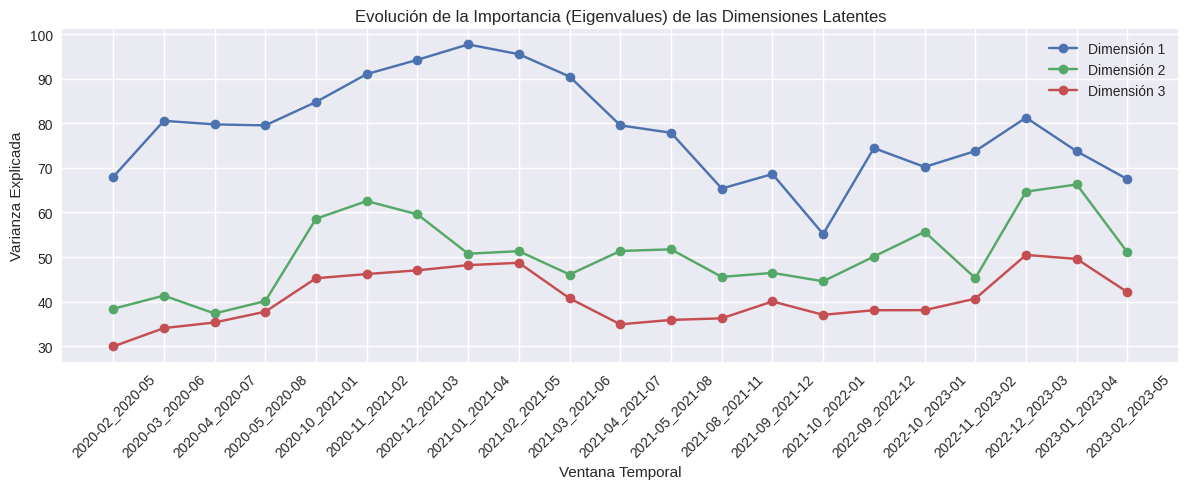

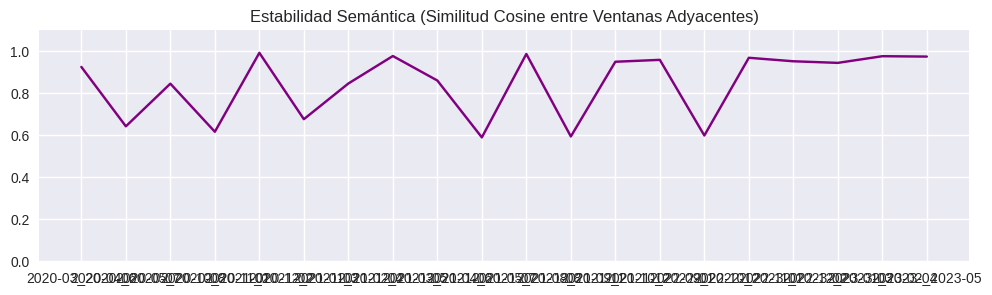


Calculando Deriva del Centroide (Euclidean Distance)...


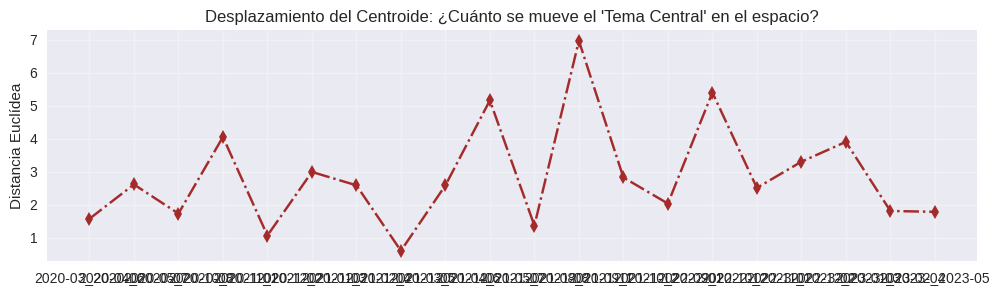

In [5]:
from src.analysis.subspaces import SubspaceConstructor

constructor = SubspaceConstructor()
# Construimos subespacios (usando k=Horn's PA automático o fijando uno para visualización)
# Para este demo, fijaremos k=3 para facilitar la inspección
subspaces = constructor.build_subspaces(windows, fixed_k=3, align=True)

print(f"Se han construido {len(subspaces)} subespacios alineados temporalmente.")

if len(subspaces) > 1:
    # Inspeccionar Evolución
    dates = [s.label for s in subspaces]
    eigenvals_evolution = np.array([s.eigenvalues for s in subspaces])

    plt.figure(figsize=(12, 5))
    for i in range(3):
        plt.plot(dates, eigenvals_evolution[:, i], marker='o', label=f'Dimensión {i+1}')

    plt.title("Evolución de la Importancia (Eigenvalues) de las Dimensiones Latentes")
    plt.xlabel("Ventana Temporal")
    plt.ylabel("Varianza Explicada")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Verificación de Alineamiento (Similitud entre ventanas adyacentes)
    similarities = []
    for i in range(1, len(subspaces)):
        # Similitud simple: traza del producto de bases alineadas
        s_prev = subspaces[i-1]
        s_curr = subspaces[i]
        # Rango 0-1 (aproximado)
        sim = np.trace(np.abs(np.dot(s_prev.basis, s_curr.basis.T))) / s_prev.k
        similarities.append(sim)

    plt.figure(figsize=(12, 3))
    plt.plot(dates[1:], similarities, color='purple', marker='x')
    plt.title("Estabilidad Semántica (Similitud Cosine entre Ventanas Adyacentes)")
    plt.ylim(0, 1.1)
    plt.show()

    # --- NUEVO: Deriva del Centroide (Desplazamiento del tema central) ---
    print("\nCalculando Deriva del Centroide (Euclidean Distance)...")
    centroid_drift = []
    
    for i in range(1, len(subspaces)):
        c_prev = subspaces[i-1].centroid
        c_curr = subspaces[i].centroid
        # Distancia euclídea entre medias
        dist = np.linalg.norm(c_curr - c_prev)
        centroid_drift.append(dist)
        
    plt.figure(figsize=(12, 3))
    plt.plot(dates[1:], centroid_drift, color='brown', marker='d', linestyle='-.')
    plt.title("Desplazamiento del Centroide: ¿Cuánto se mueve el 'Tema Central' en el espacio?")
    plt.ylabel("Distancia Euclídea")
    plt.grid(True, alpha=0.3)
    plt.show()



## Paso 5: Métricas Sociológicas
**Fase 3.4**

Finalmente, traducimos la geometría a respuestas.

1.  **Deriva Semántica**: ¿Cuánto ha cambiado Yape? (Gráfico de línea descendente si hay cambios).
2.  **Complejidad (Entropía)**: ¿Se ha vuelto más complejo? (Barras de entropía).
3.  **Proyecciones Teóricas (HÍBRIDO)**: 
    *   **Contextual**: Significado en uso. 
    *   **Estático (Baseline)**: Significado de diccionario (técnico).
    *   *Si Contextual > Estático*: Yape se usa como se diseñó. *Si Contextual < Estático*: Yape ha mutado.

Usaremos `src.analysis.metrics.SociologicalMetrics`.

Anclas cargados: 74

--- Deriva Semántica (Primeras filas) ---
              date  similarity     drift
0  2020-02_2020-05    1.000000  0.000000
1  2020-03_2020-06    0.925460  0.074540
2  2020-04_2020-07    0.642648  0.357352
3  2020-05_2020-08    0.845811  0.154189
4  2020-10_2021-01    0.616712  0.383288


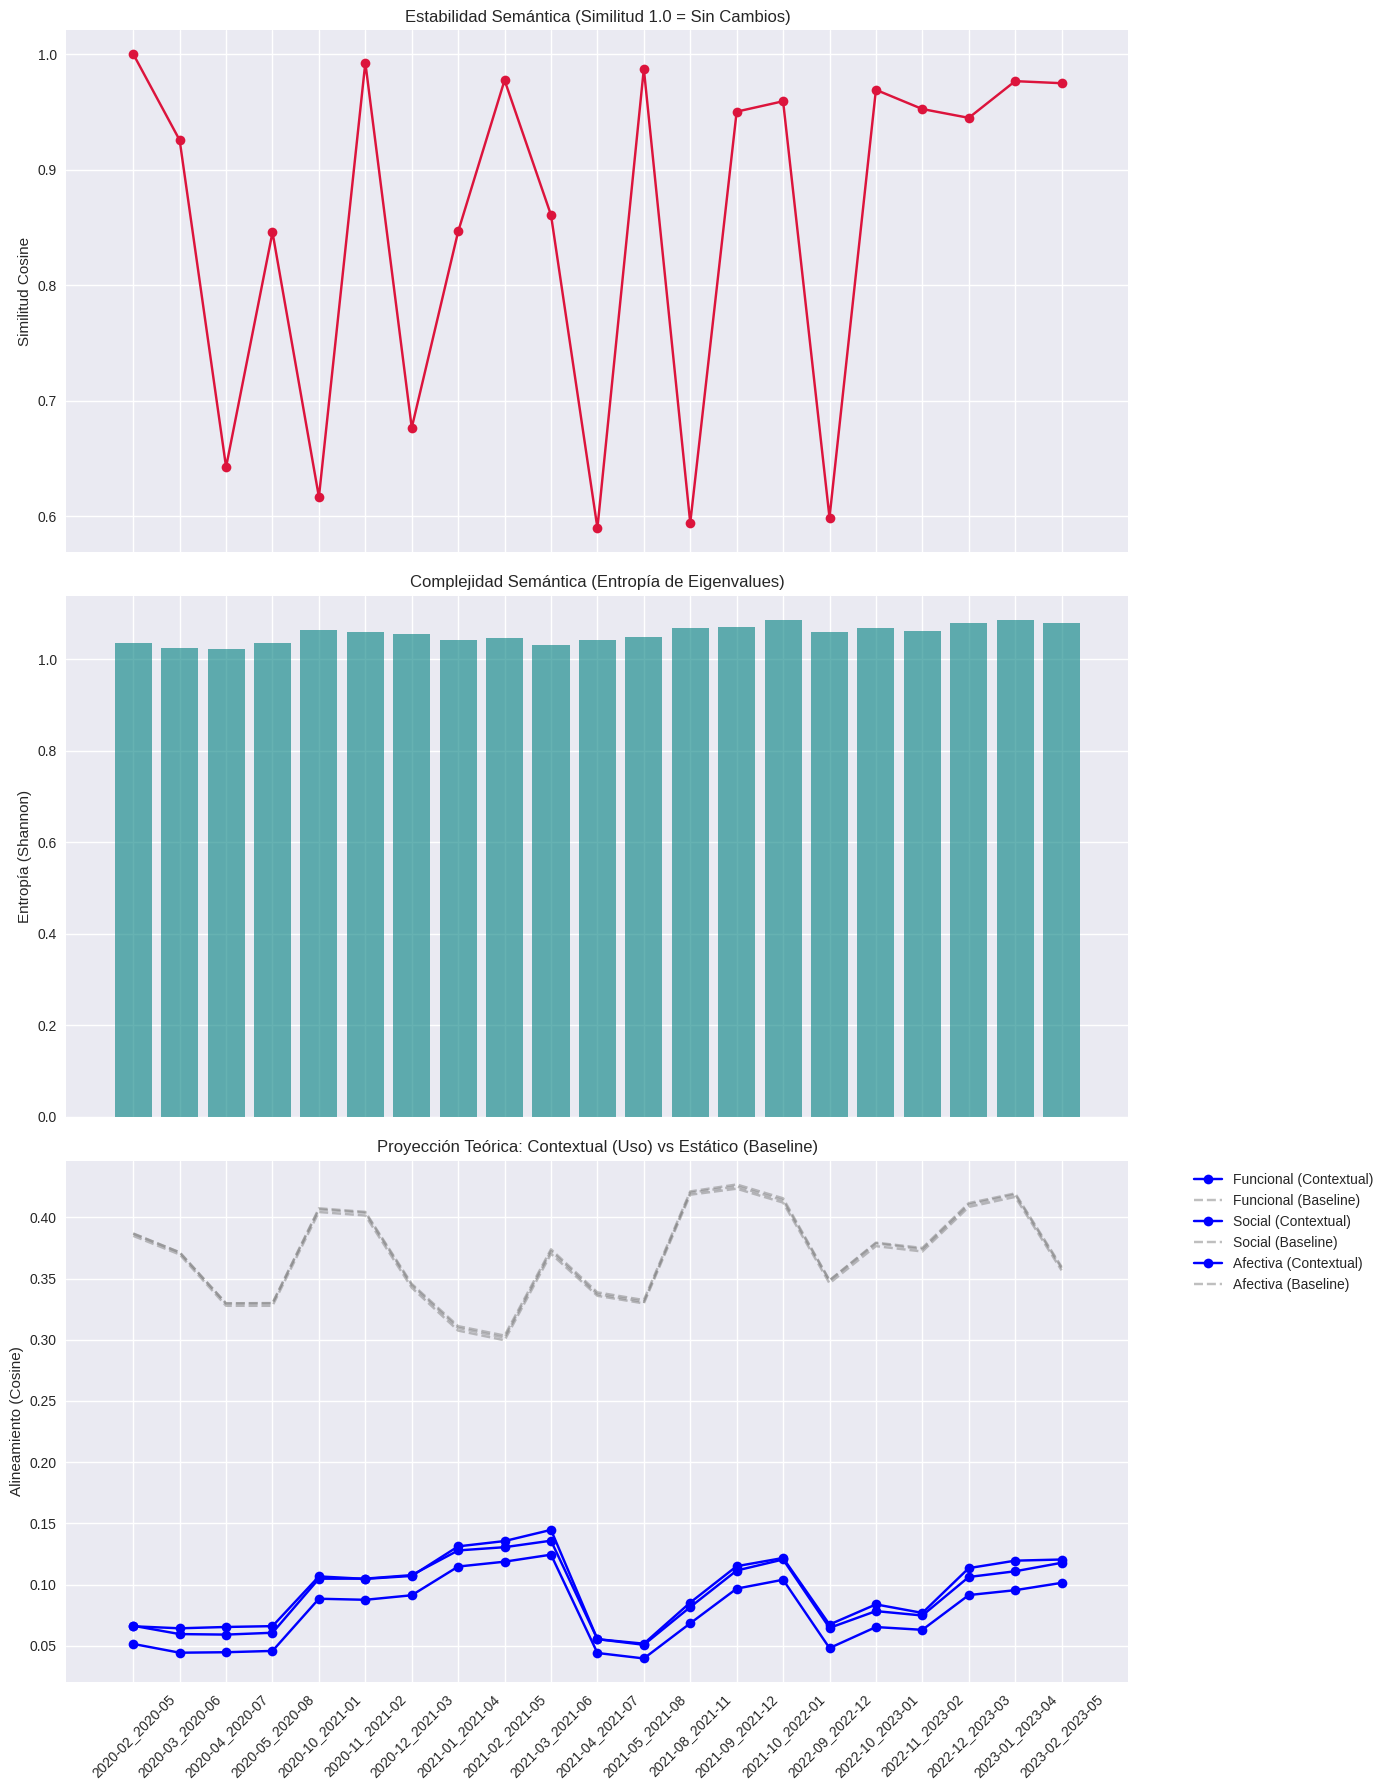

In [6]:
from src.analysis.metrics import SociologicalMetrics

# Cargar Anclas para proyección
anchors_path = 'data/anchors_embeddings.parquet'
# Búsqueda robusta de anclas
possible_anchors_paths = [
    anchors_path, 
    '../' + anchors_path,
    os.path.join(os.getcwd(), 'data', 'anchors_embeddings.parquet') 
]
final_anchors_path = None
for p in possible_anchors_paths:
    if os.path.exists(p):
        final_anchors_path = p
        break

if final_anchors_path:
    anchors_df = pd.read_parquet(final_anchors_path)
    print(f"Anclas cargados: {len(anchors_df)}")
    
    metrics_calc = SociologicalMetrics()

    # 1. Deriva
    drift_df = metrics_calc.calculate_drift(subspaces)
    print("\n--- Deriva Semántica (Primeras filas) ---")
    print(drift_df.head())

    # 2. Entropía
    entropy_df = metrics_calc.calculate_entropy(subspaces)

    # 3. Proyecciones
    proj_df = metrics_calc.calculate_projections(subspaces, anchors_df)
    
    # --- VISUALIZACIÓN FINAL ---
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

    # A. DRIFT
    axes[0].plot(drift_df['date'], drift_df['similarity'], color='crimson', marker='o')
    axes[0].set_title("Estabilidad Semántica (Similitud 1.0 = Sin Cambios)")
    axes[0].set_ylabel("Similitud Cosine")
    axes[0].grid(True)

    # B. ENTROPY
    axes[1].bar(entropy_df['date'], entropy_df['entropy'], color='teal', alpha=0.6)
    axes[1].set_title("Complejidad Semántica (Entropía de Eigenvalues)")
    axes[1].set_ylabel("Entropía (Shannon)")
    axes[1].grid(True)

    # C. PROJECTIONS (CONTRAST)
    dimensions = set([c.split('_')[1] for c in proj_df.columns if c.startswith('score_')])
    
    colors = {'contextual': 'blue', 'static': 'grey'}
    styles = {'contextual': '-', 'static': '--'}
    
    for dim in ['funcional', 'social', 'afectiva']:
        # Plot Contextual
        col_ctx = f'score_{dim}_contextual'
        if col_ctx in proj_df.columns:
            axes[2].plot(proj_df['date'], proj_df[col_ctx], 
                        color=colors['contextual'], linestyle=styles['contextual'], marker='o', 
                        label=f'{dim.capitalize()} (Contextual)')
                        
        # Plot Static
        col_sta = f'score_{dim}_static'
        if col_sta in proj_df.columns:
            axes[2].plot(proj_df['date'], proj_df[col_sta], 
                        color=colors['static'], linestyle=styles['static'], marker='x', alpha=0.5,
                        label=f'{dim.capitalize()} (Baseline)')

    axes[2].set_title("Proyección Teórica: Contextual (Uso) vs Estático (Baseline)")
    axes[2].set_ylabel("Alineamiento (Cosine)")
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[2].grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("ADVERTENCIA: No se encontraron anclas. No se pueden calcular proyecciones.")
